## Load modules

In [2]:
# To reload external files automatically (ex: utils)
%load_ext autoreload
%autoreload 2

import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import proplot as plot # New plot library (https://proplot.readthedocs.io/en/latest/)
from scipy import stats
import xesmf as xe # For regridding (https://xesmf.readthedocs.io/en/latest/)

import sys
sys.path.insert(1, '../../../') # to include my util file in previous directory
import utils as u # my personal functions
u.check_python_version()
u.check_virtual_memory()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
3.7.6 (default, Jan  8 2020, 19:59:22) 
[GCC 7.3.0]
Virtual memory usage - total: 252 GB / available: 55 GB / percent used: 77.9 %


## Load model data

In [3]:
# Define period
period = slice('1981','2014')

In [4]:
institute = 'IPSL'
model = 'IPSL-CM6A-LR'
realization = 'r1i1p1f1'
var = 'pr'
if var in ['tas', 'pr']:
    table = 'Amon'

In [5]:
# Load historical
da_historical = xr.open_mfdataset(
    '/bdd/CMIP6/CMIP/'+institute+'/'+model+'/historical/'+realization+'/'+table+'/'+var+'/gr/latest/*.nc', combine='by_coords'
).sel(time=period)[var]

# Load amip
da_amip = xr.open_mfdataset(
    '/bdd/CMIP6/CMIP/'+institute+'/'+model+'/amip/'+realization+'/'+table+'/'+var+'/gr/latest/*.nc', combine='by_coords'
).sel(time=period)[var]

# Load land-hist
da_land_hist = xr.open_mfdataset(
    '/bdd/CMIP6/LS3MIP/'+institute+'/'+model+'/land-hist/'+realization+'/'+table+'/'+var+'/gr/latest/*.nc', combine='by_coords'
).sel(time=period)[var]

# Load HighResMIP
da_HR = xr.open_mfdataset(
    '/bdd/CMIP6/HighResMIP/'+institute+'/IPSL-CM6A-ATM-HR/highresSST-present/'+realization+'/'+table+'/'+var+'/gr/latest/*.nc', combine='by_coords'
).sel(time=period)[var]

In [5]:
da_HR

<xarray.DataArray 'pr' (time: 408, lat: 361, lon: 512)>
dask.array<getitem, shape=(408, 361, 512), dtype=float32, chunksize=(408, 361, 512), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 -90.0 -89.5 -89.0 -88.5 -88.0 ... 88.5 89.0 89.5 90.0
  * lon      (lon) float32 0.0 0.703125 1.40625 ... 358.59375 359.29688
  * time     (time) datetime64[ns] 1981-01-16T12:00:00 ... 2014-12-16T12:00:00
Attributes:
    long_name:           Precipitation
    units:               kg m-2 s-1
    online_operation:    average
    cell_methods:        area: time: mean
    interval_operation:  900 s
    interval_write:      1 month
    standard_name:       precipitation_flux
    description:         at surface; includes both liquid and solid phases fr...
    history:             none
    cell_measures:       area: areacella

## Load obs 
APHRODITE http://aphrodite.st.hirosaki-u.ac.jp/download/data/search/  
http://aphrodite.st.hirosaki-u.ac.jp/download/
V1101 et V1101EX_R1 domain MA

Attention unité mm/day and kg/m2/s for model -> x 86400

In [6]:
obs_V1101 = xr.open_mfdataset(
    '/data/mlalande/APHRODITE/APHRO_MA_050deg_V1101.*.nc', combine='by_coords'
).precip
obs_V1101

<xarray.DataArray 'precip' (time: 9496, latitude: 140, longitude: 180)>
dask.array<concatenate, shape=(9496, 140, 180), dtype=float32, chunksize=(366, 140, 180), chunktype=numpy.ndarray>
Coordinates:
  * latitude   (latitude) float64 -14.75 -14.25 -13.75 ... 53.75 54.25 54.75
  * longitude  (longitude) float64 60.25 60.75 61.25 61.75 ... 148.8 149.2 149.8
  * time       (time) datetime64[ns] 1981-01-01 1981-01-02 ... 2006-12-31
Attributes:
    long_name:          daily precipitation analysis interpolated onto 0.5deg...
    units:              mm/day
    level_description:  Earth surface

In [7]:
obs_V1101_EXR1 = xr.open_mfdataset(
    '/data/mlalande/APHRODITE/APHRO_MA_050deg_V1101_EXR1.*.nc', combine='by_coords'
).precip
obs_V1101_EXR1

<xarray.DataArray 'precip' (time: 2922, lat: 140, lon: 180)>
dask.array<concatenate, shape=(2922, 140, 180), dtype=float32, chunksize=(366, 140, 180), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 -14.75 -14.25 -13.75 -13.25 ... 53.75 54.25 54.75
  * lon      (lon) float64 60.25 60.75 61.25 61.75 ... 148.2 148.8 149.2 149.8
  * time     (time) datetime64[ns] 2007-01-01 2007-01-02 ... 2014-12-31
Attributes:
    units:      mm
    long_name:   daily precipitation analysis interpolated onto 0.50deg grids

In [8]:
obs_V1101 = obs_V1101.rename({'longitude': 'lon', 'latitude': 'lat'})

In [9]:
obs = xr.combine_nested([obs_V1101, obs_V1101_EXR1], concat_dim='time')
obs

<xarray.DataArray 'precip' (time: 12418, lat: 140, lon: 180)>
dask.array<concatenate, shape=(12418, 140, 180), dtype=float32, chunksize=(366, 140, 180), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 -14.75 -14.25 -13.75 -13.25 ... 53.75 54.25 54.75
  * lon      (lon) float64 60.25 60.75 61.25 61.75 ... 148.2 148.8 149.2 149.8
  * time     (time) datetime64[ns] 1981-01-01 1981-01-02 ... 2014-12-31

In [10]:
obs = obs.resample(time='1MS').mean('time', skipna='False', keep_attrs=True)
obs

<xarray.DataArray 'precip' (time: 408, lat: 140, lon: 180)>
dask.array<stack, shape=(408, 140, 180), dtype=float32, chunksize=(1, 140, 180), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 1981-01-01 1981-02-01 ... 2014-12-01
  * lat      (lat) float64 -14.75 -14.25 -13.75 -13.25 ... 53.75 54.25 54.75
  * lon      (lon) float64 60.25 60.75 61.25 61.75 ... 148.2 148.8 149.2 149.8

### Regrid using xESMF (https://xesmf.readthedocs.io/en/latest/) 
obs + HR

In [11]:
# For adding NaN values outside of the grid, otherwise it puts 0 (see issue just up #15)
import scipy
def add_matrix_NaNs(regridder):
    X = regridder.weights
    M = scipy.sparse.csr_matrix(X)
    num_nonzeros = np.diff(M.indptr)
    M[num_nonzeros == 0, 0] = np.NaN
    regridder.weights = scipy.sparse.coo_matrix(M)
    return regridder

In [12]:
# Make the regrider
regridder_obs = xe.Regridder(obs, da_historical, 'bilinear', periodic=False)
regridder_obs = add_matrix_NaNs(regridder_obs)
regridder_obs

Overwrite existing file: bilinear_140x180_143x144.nc 
 You can set reuse_weights=True to save computing time.


/home/mlalande/miniconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


xESMF Regridder 
Regridding algorithm:       bilinear 
Weight filename:            bilinear_140x180_143x144.nc 
Reuse pre-computed weights? False 
Input grid shape:           (140, 180) 
Output grid shape:          (143, 144) 
Output grid dimension name: ('lat', 'lon') 
Periodic in longitude?      False

In [13]:
# Regrid the data
obs_regrid = regridder_obs(obs)

/home/mlalande/miniconda3/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: divide by zero encountered in true_divide
  x = np.divide(x1, x2, out)
/home/mlalande/miniconda3/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


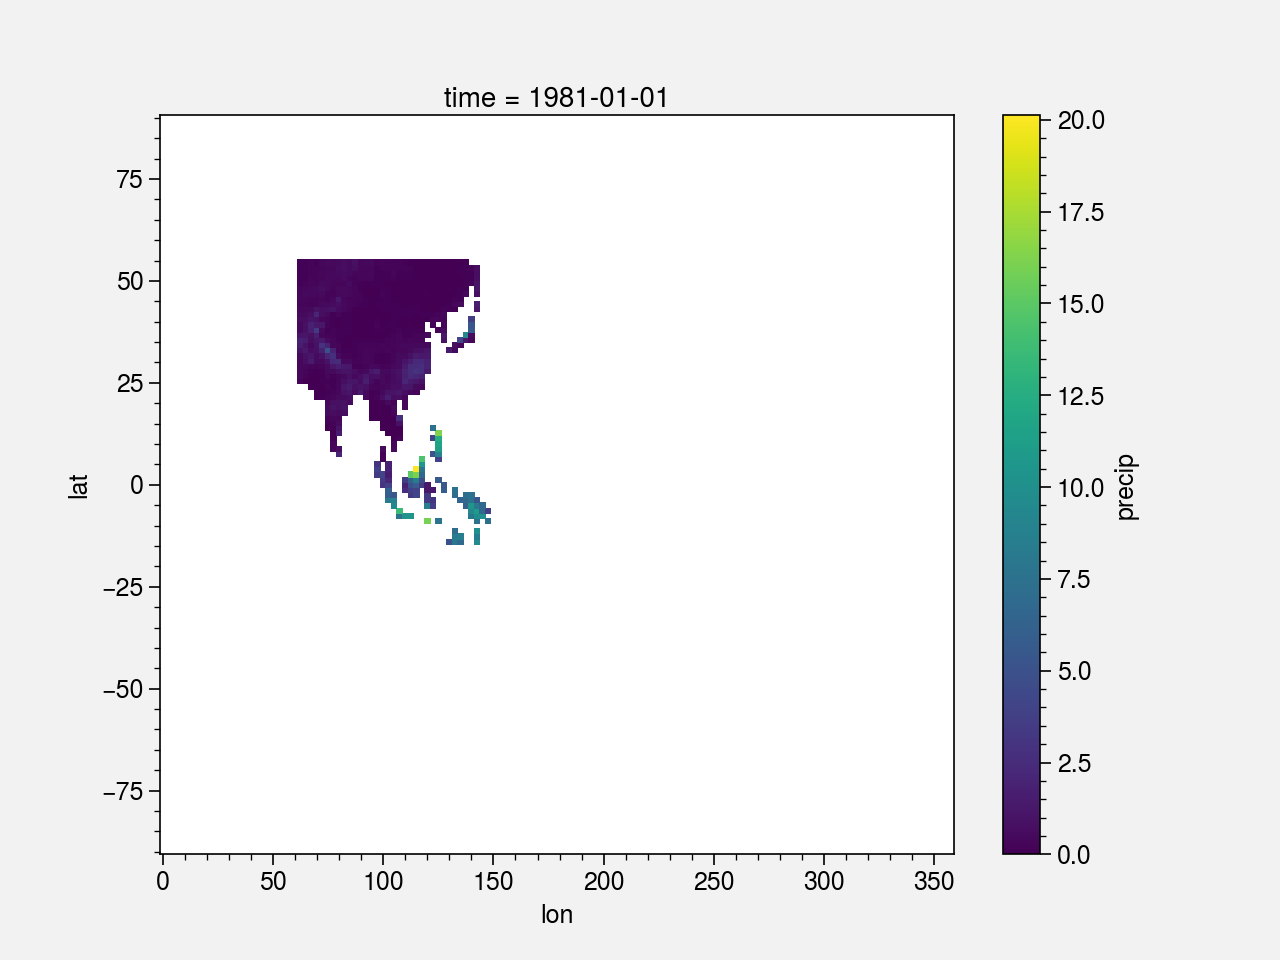

In [15]:
obs_regrid[0].plot()

In [16]:
# Regrid HighResMIP
regridder_HR = xe.Regridder(da_HR, da_historical, 'bilinear', periodic=True)
regridder_HR

Overwrite existing file: bilinear_361x512_143x144_peri.nc 
 You can set reuse_weights=True to save computing time.


xESMF Regridder 
Regridding algorithm:       bilinear 
Weight filename:            bilinear_361x512_143x144_peri.nc 
Reuse pre-computed weights? False 
Input grid shape:           (361, 512) 
Output grid shape:          (143, 144) 
Output grid dimension name: ('lat', 'lon') 
Periodic in longitude?      True

In [17]:
# Regrid the data
da_HR_regrid = regridder_HR(da_HR)

# Check monthly precipitations (for 3 boxes?)

/home/mlalande/miniconda3/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: divide by zero encountered in true_divide
  x = np.divide(x1, x2, out)
/home/mlalande/miniconda3/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


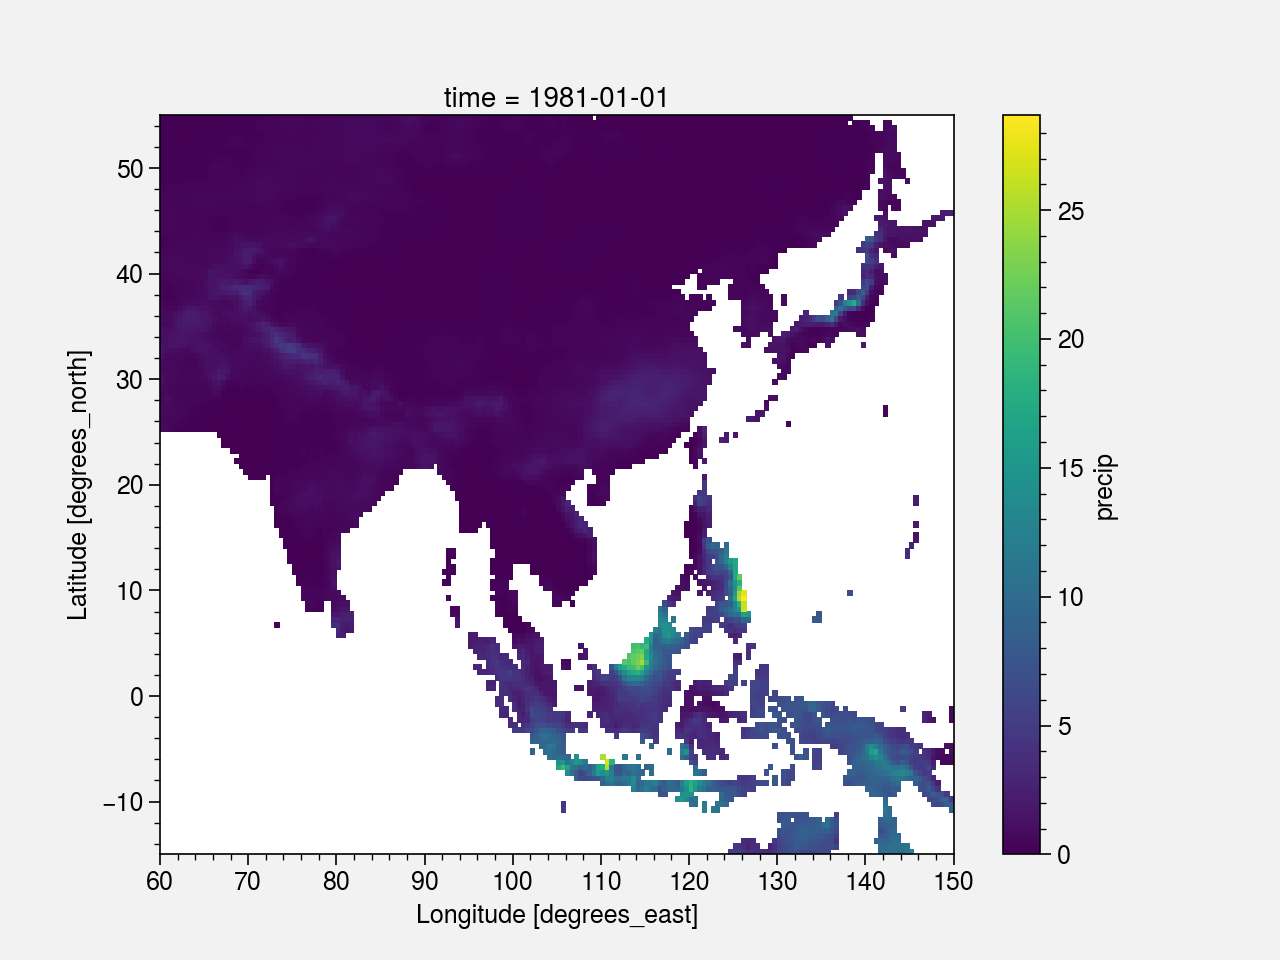

In [19]:
obs[0].plot()

/home/mlalande/miniconda3/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: divide by zero encountered in true_divide
  x = np.divide(x1, x2, out)
/home/mlalande/miniconda3/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


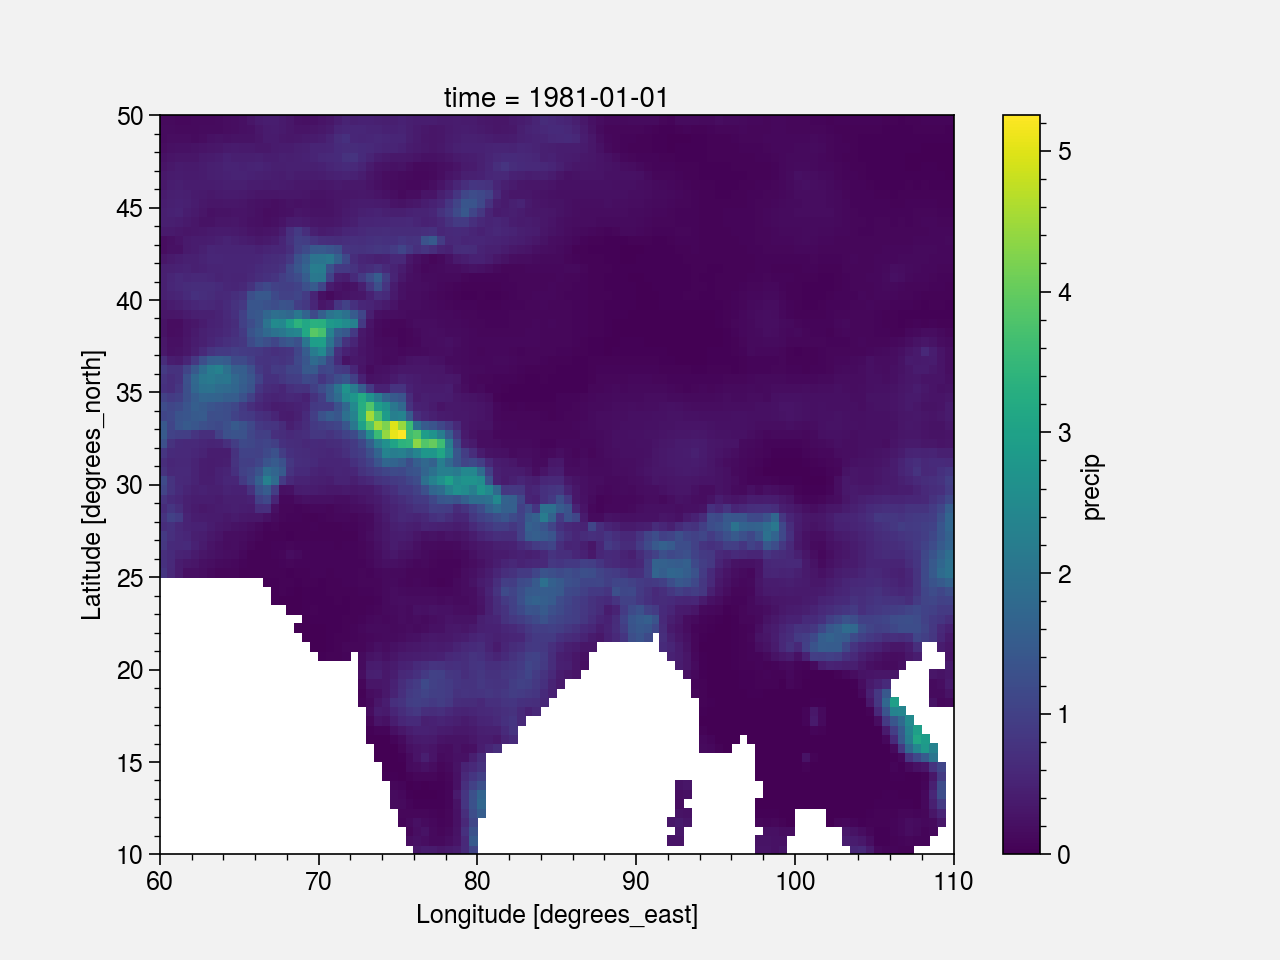

In [20]:
latlim=(10,50)
lonlim=(60,110)

obs.sel(lat=slice(latlim[0],latlim[1]), lon=slice(lonlim[0],lonlim[1]))[0].plot()

In [22]:
latlim=(10,50)
lonlim=(60,110)

obs_mon = obs.sel(lat=slice(latlim[0],latlim[1]), lon=slice(lonlim[0],lonlim[1])).groupby('time.month').mean('time')
obs_mon.load()

/home/mlalande/miniconda3/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: divide by zero encountered in true_divide
  x = np.divide(x1, x2, out)
/home/mlalande/miniconda3/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


<xarray.DataArray 'precip' (month: 12, lat: 80, lon: 100)>
array([[[       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ..., 0.37375912,
                nan,        nan],
        ...,
        [0.4579026 , 0.42670208, 0.41888404, ..., 0.07926876,
         0.08096816, 0.08023174],
        [0.44689545, 0.4310173 , 0.42199838, ..., 0.10418288,
         0.10074706, 0.09884909],
        [0.46892592, 0.45859432, 0.4451656 , ..., 0.1291622 ,
         0.12700419, 0.12520824]],

       [[       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ..., 0.2639041 ,
                nan,        nan],
        ...,
        [0.5207663 , 0.4833182 , 0.47250697, ..., 0.08653964,
         0.08742592, 0.08405484],
        [0.4452393 , 0.42578727, 0.41683197, ..., 0.08821724,
         0.09037857, 0.0912922 ],
        [0.46737823, 0.4508109 , 0.43744683, ..., 0.10046624,
         0.1022513 , 0.10453802]],

       [[       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ..., 0.766369  ,
                nan,        nan],
        ...,
        [0.5349599 , 0.51313716, 0.4964829 , ..., 0.1189665 ,
         0.12971108, 0.1324175 ],
        [0.5150396 , 0.49410903, 0.47455552, ..., 0.12324259,
         0.13578159, 0.1417299 ],
        [0.547916  , 0.51677763, 0.49055964, ..., 0.12693632,
         0.14165407, 0.15437376]],

       ...,

       [[       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ..., 5.405102  ,
                nan,        nan],
        ...,
        [0.6041621 , 0.57266617, 0.55364543, ..., 0.33994138,
         0.3652443 , 0.37492967],
        [0.5820793 , 0.5615414 , 0.5440034 , ..., 0.3456519 ,
         0.37276733, 0.38200048],
        [0.61304593, 0.5893121 , 0.56442344, ..., 0.34604812,
         0.36620593, 0.39187083]],

       [[       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ..., 3.558482  ,
                nan,        nan],
        ...,
        [0.58818495, 0.5647569 , 0.55050397, ..., 0.17555755,
         0.17910865, 0.17226909],
        [0.6046226 , 0.5916961 , 0.5782892 , ..., 0.18783584,
         0.19134408, 0.19333419],
        [0.6344596 , 0.61729366, 0.60237795, ..., 0.2195809 ,
         0.22681046, 0.2343112 ]],

       [[       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ..., 1.6127338 ,
                nan,        nan],
        ...,
        [0.5482283 , 0.52107465, 0.5110794 , ..., 0.11676843,
         0.11821298, 0.11348857],
        [0.55342036, 0.5391679 , 0.53247595, ..., 0.1444389 ,
         0.14164543, 0.14035407],
        [0.5782368 , 0.57035726, 0.5596775 , ..., 0.18354027,
         0.18238494, 0.1809684 ]]], dtype=float32)
Coordinates:
  * lat      (lat) float64 10.25 10.75 11.25 11.75 ... 48.25 48.75 49.25 49.75
  * lon      (lon) float64 60.25 60.75 61.25 61.75 ... 108.2 108.8 109.2 109.8
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12

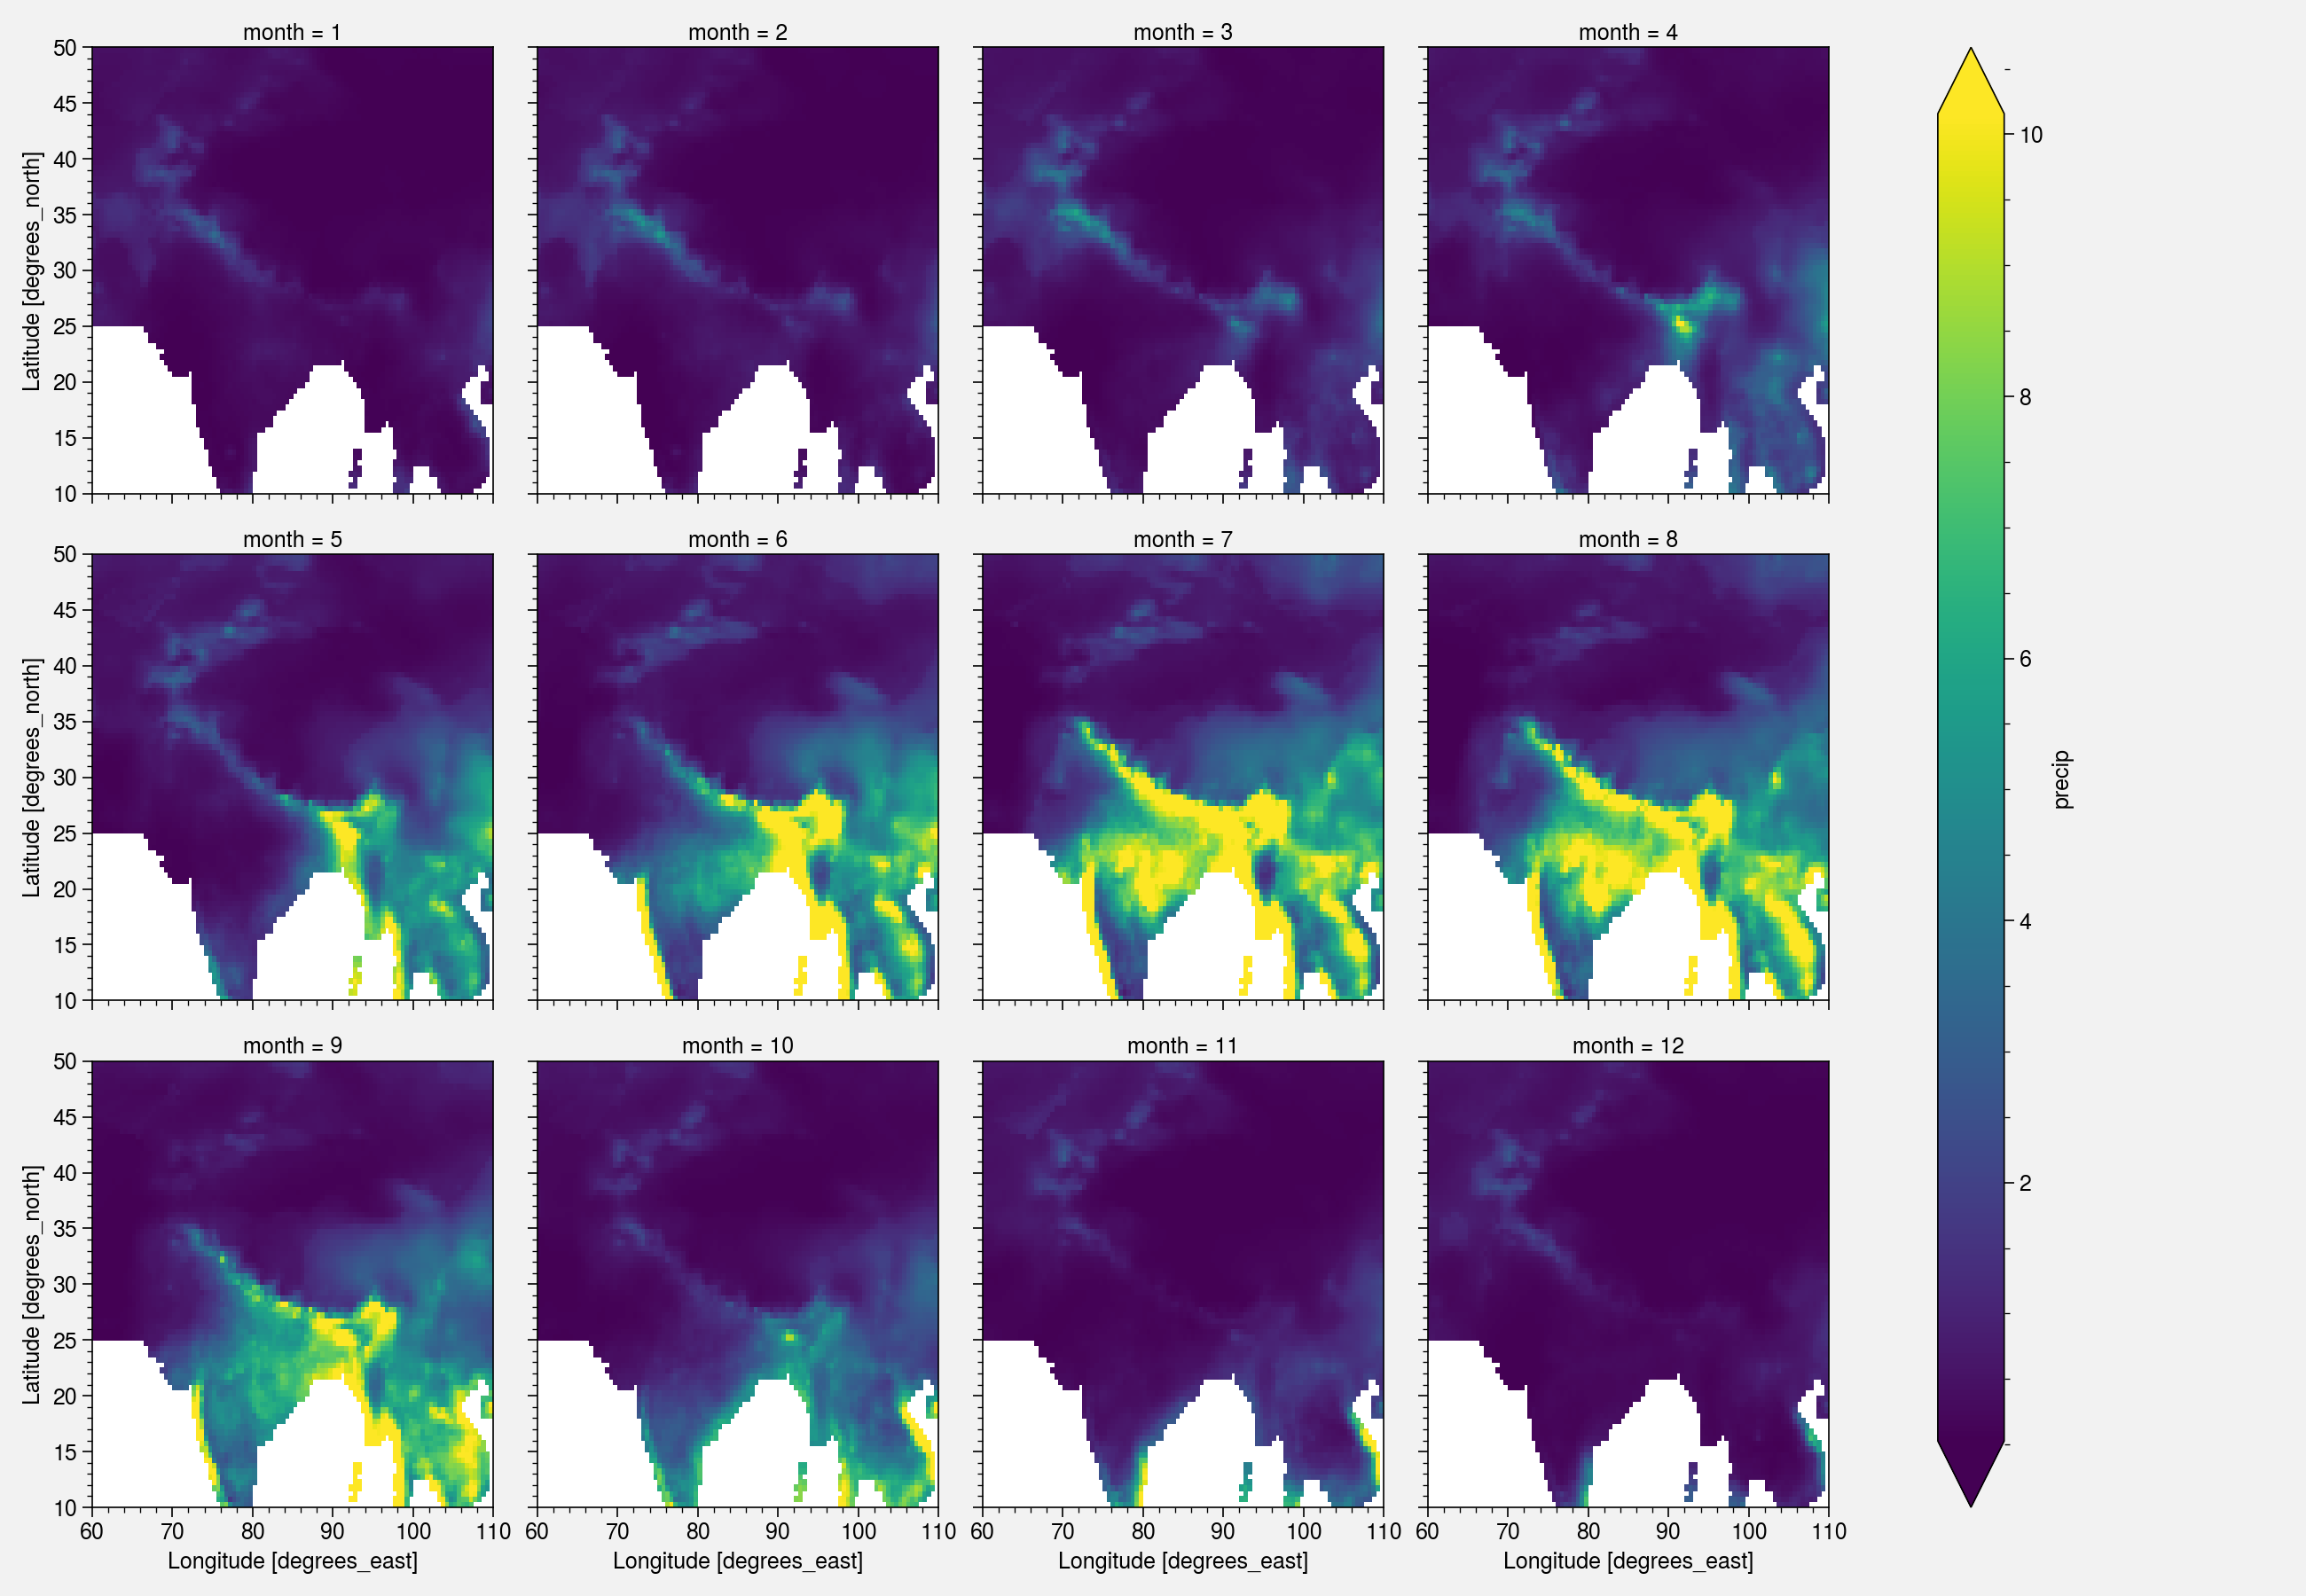

In [34]:
obs_mon.plot(col='month', col_wrap=4, robust=True)

In [27]:
obs_V1101

<xarray.DataArray 'precip' (time: 9496, lat: 140, lon: 180)>
dask.array<concatenate, shape=(9496, 140, 180), dtype=float32, chunksize=(366, 140, 180), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 -14.75 -14.25 -13.75 -13.25 ... 53.75 54.25 54.75
  * lon      (lon) float64 60.25 60.75 61.25 61.75 ... 148.2 148.8 149.2 149.8
  * time     (time) datetime64[ns] 1981-01-01 1981-01-02 ... 2006-12-31
Attributes:
    long_name:          daily precipitation analysis interpolated onto 0.5deg...
    units:              mm/day
    level_description:  Earth surface

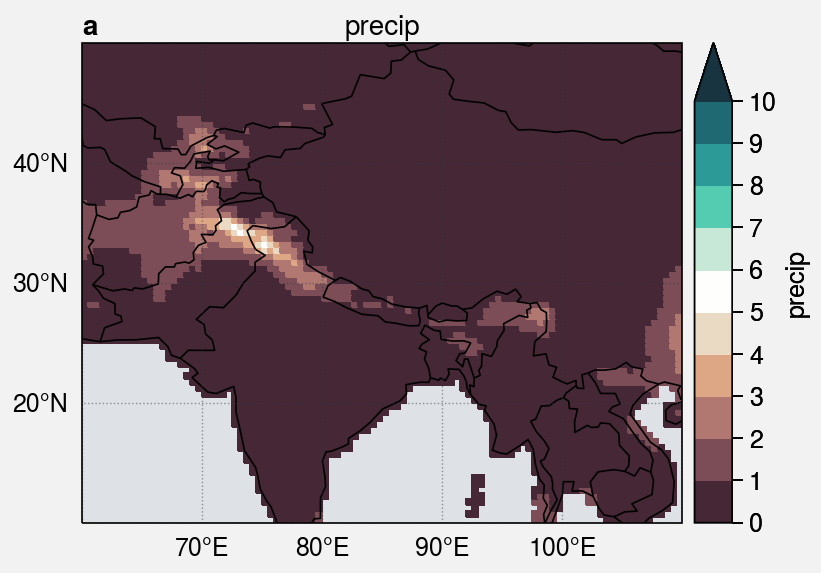

In [42]:
# Check colorbars extent

f, axs = plot.subplots(proj='cyl', axwidth=3)

axs.pcolormesh(
        obs_mon.isel(month=1), 
        cmap='DryWet',  
        colorbar='r',
#         norm='midpoint',
        levels=plot.arange(0,10,1),
        extend='max'
    )

axs.format(
    geogridlinewidth=0.5, geogridcolor='gray8', geogridalpha=0.5, labels=True, 
    coast=True, ocean=True, oceancolor='gray3', borders=True,
    lonlines=10, latlines=10, abc=True, latlim=latlim, lonlim=lonlim
)

In [38]:
import calendar
calendar.month_name[3]

'March'

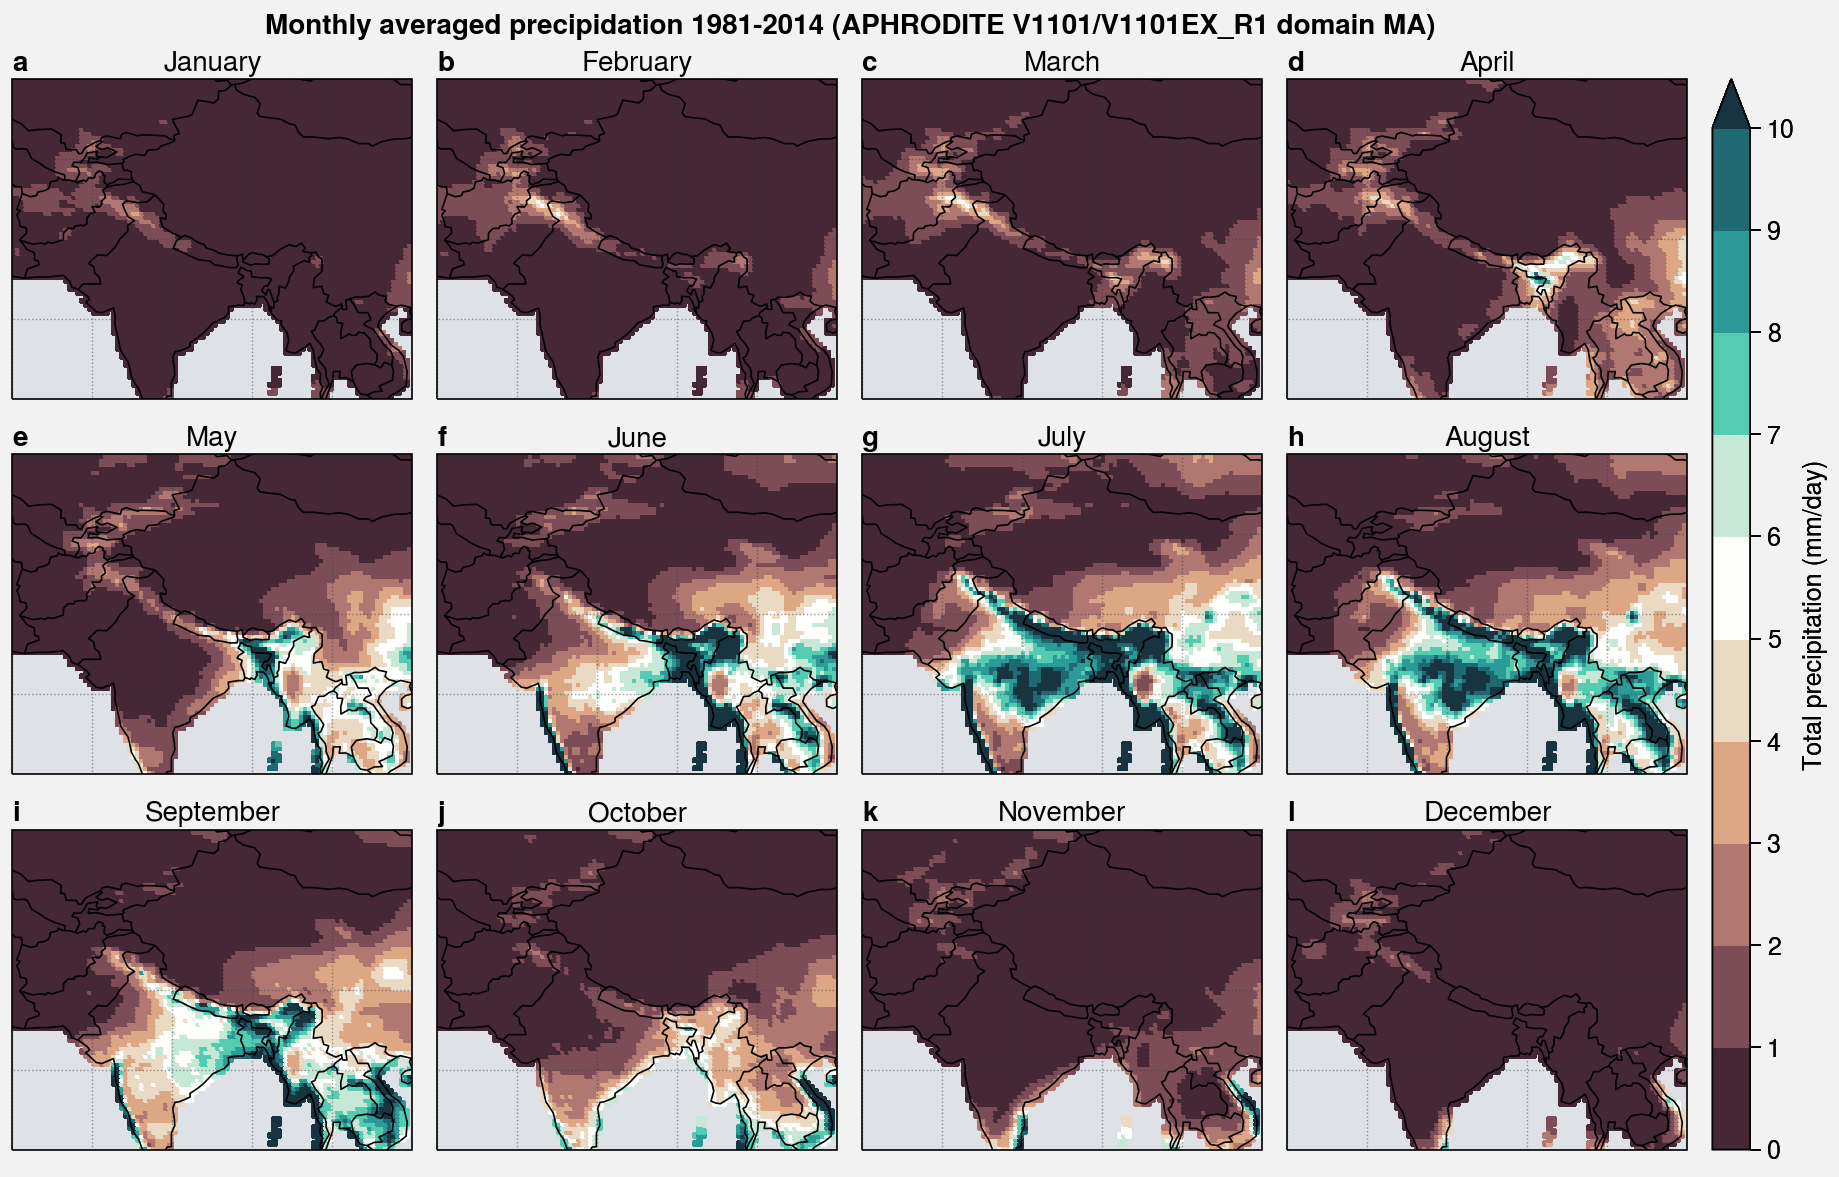

In [51]:
import calendar

f, axs = plot.subplots(proj='cyl', ncols=4, nrows=3, share=3, axwidth=2)

for i, ax in enumerate(axs):
    m = ax.pcolormesh(
        obs_mon.isel(month=i), 
        cmap='DryWet',  
#         colorbar='r',
        levels=plot.arange(0,10,1),
        extend='max'
    )
    ax.format(title=calendar.month_name[i+1])
    
f.colorbar(m, label='Total precipitation (mm/day)')

axs.format(
    geogridlinewidth=0.5, geogridcolor='gray8', geogridalpha=0.5, labels=False, 
    coast=True, ocean=True, oceancolor='gray3', borders=True,
    suptitle="Monthly averaged precipidation 1981-2014 (APHRODITE V1101/V1101EX_R1 domain MA)",
    lonlines=10, latlines=10, abc=True, latlim=latlim, lonlim=lonlim
)

f.save('img/precip/mon_precip_APHRODITE_1981-2014.png')

## Annual Climatology

In [18]:
da_historical_clim = u.clim(da_historical)
da_historical_clim.load()

da_amip_clim = u.clim(da_amip)
da_amip_clim.load()

da_land_hist_clim = u.clim(da_land_hist)
da_land_hist_clim.load()

obs_regrid_clim = u.clim(obs_regrid)
obs_regrid_clim.load()

da_HR_regrid_clim = u.clim(da_HR_regrid)
da_HR_regrid_clim.load()

/home/mlalande/miniconda3/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: divide by zero encountered in true_divide
  x = np.divide(x1, x2, out)
/home/mlalande/miniconda3/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


<xarray.DataArray (lat: 143, lon: 144)>
array([[1.01048974e-06, 1.01048974e-06, 1.01048974e-06, ...,
        1.01048974e-06, 1.01048974e-06, 1.01048974e-06],
       [2.01212286e-06, 1.77845479e-06, 1.75585594e-06, ...,
        1.88813409e-06, 1.87546862e-06, 1.91167651e-06],
       [1.60559569e-06, 1.53942378e-06, 1.51192191e-06, ...,
        1.61735430e-06, 1.60759005e-06, 1.60895563e-06],
       ...,
       [7.57696721e-06, 7.53386596e-06, 7.54037407e-06, ...,
        7.35905709e-06, 7.39422249e-06, 7.42161540e-06],
       [7.20729306e-06, 7.18925025e-06, 7.21217289e-06, ...,
        7.04875426e-06, 7.06585149e-06, 7.09363609e-06],
       [3.70566805e-06, 3.70566805e-06, 3.70566805e-06, ...,
        3.70566805e-06, 3.70566805e-06, 3.70566805e-06]])
Coordinates:
  * lon      (lon) float32 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
  * lat      (lat) float32 -90.0 -88.73239 -87.46479 ... 87.46479 88.73239 90.0
Attributes:
    regrid_method:  bilinear

In [19]:
latlim=(10,50)
lonlim=(60,110)

bias = xr.concat(
    [
        ((da_historical_clim*86400)-obs_regrid_clim)*365,
        ((da_amip_clim*86400)-obs_regrid_clim)*365,
        ((da_land_hist_clim*86400)-obs_regrid_clim)*365,
        ((da_HR_regrid_clim*86400)-obs_regrid_clim)*365
    ],
    pd.Index(
        [
            'Historical (143x144) - APHRODITE (0.5°)',
            'AMIP (143x144) - APHRODITE (0.5°)',
            'land-hist (143x144) - APHRODITE (0.5°)',
            'HighResMIP (361x512) - APHRODITE (0.5°)'
        ], 
        name='bias'
    )
).sel(lat=slice(latlim[0],latlim[1]), lon=slice(lonlim[0],lonlim[1]))

https://rmets-onlinelibrary-wiley-com.gaelnomade-2.grenet.fr/doi/epdf/10.1002/joc.6509

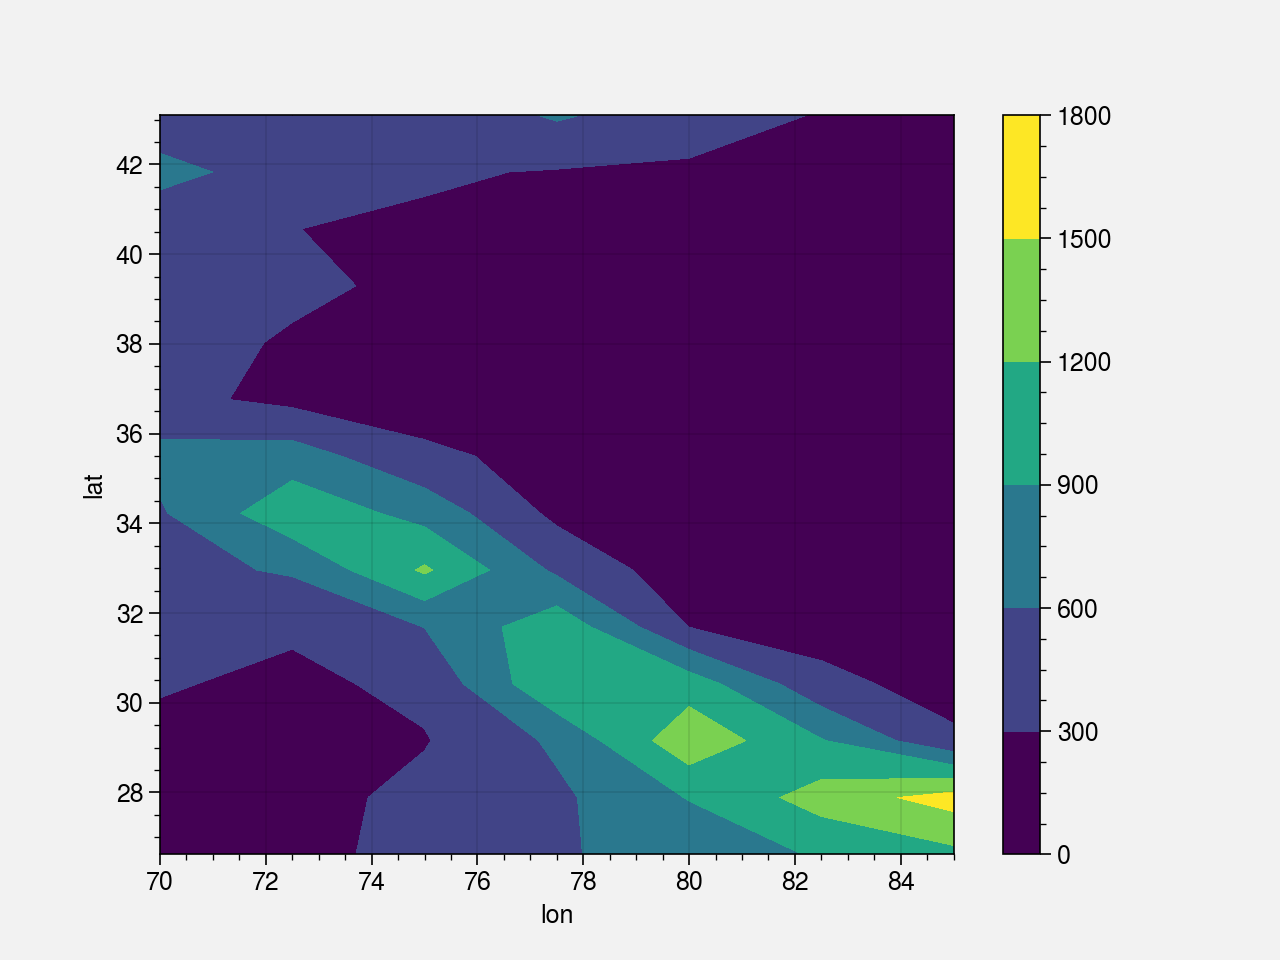

In [20]:
(obs_regrid_clim*365).sel(lat=slice(26,44), lon=slice(70,85)).plot.contourf()

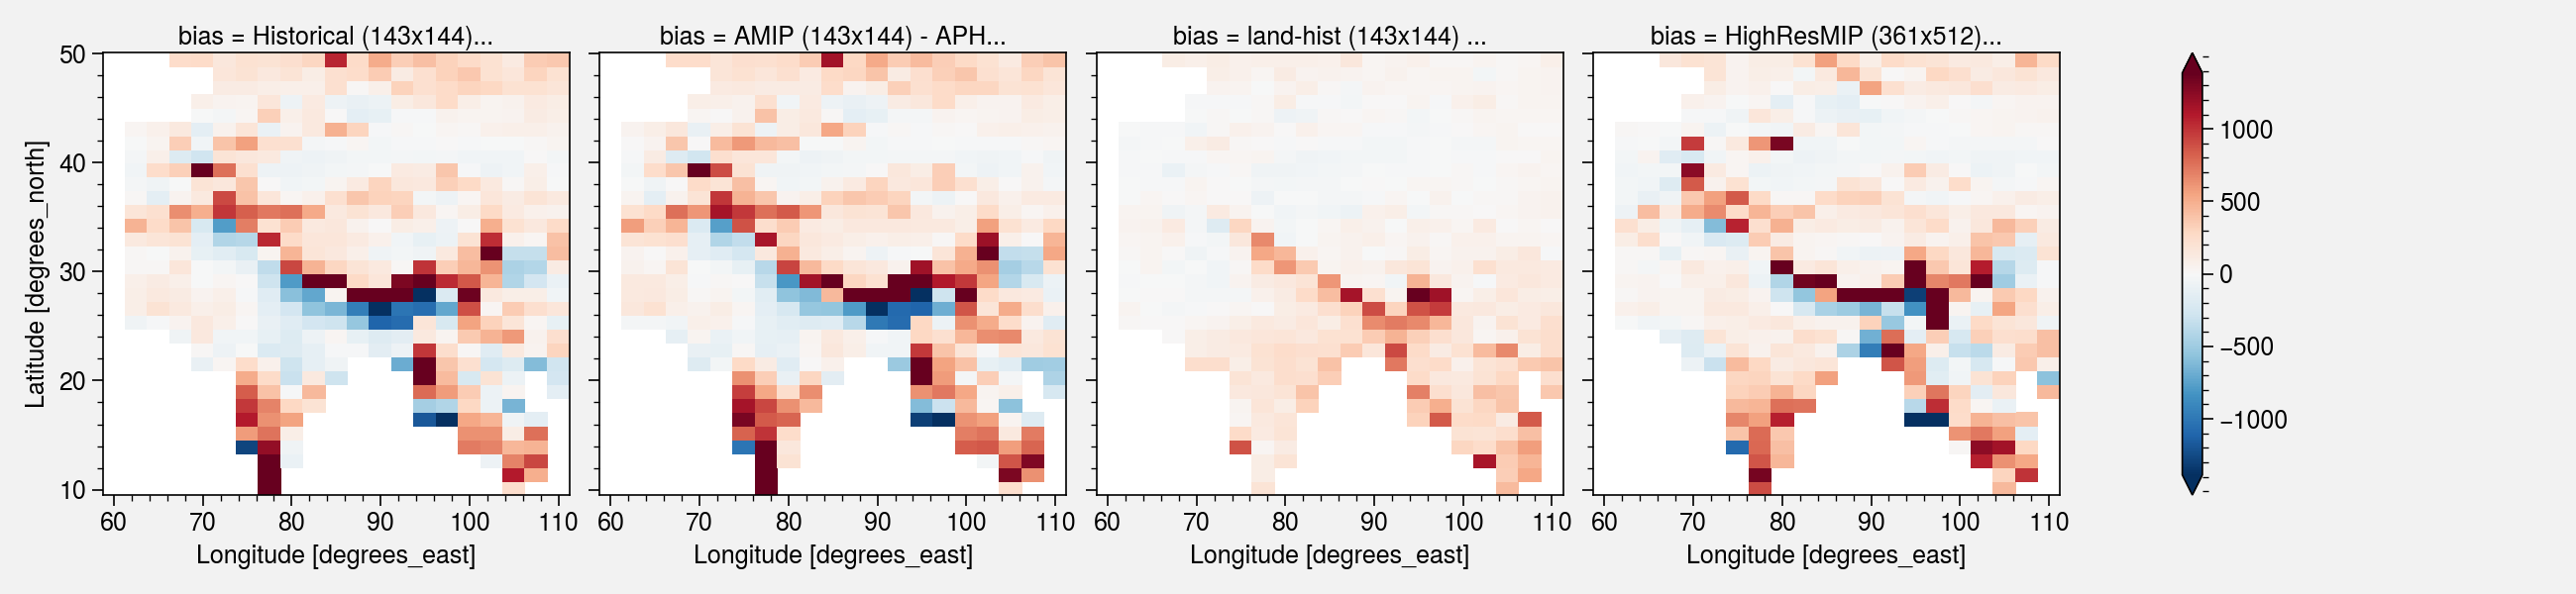

In [21]:
bias.plot(col='bias', robust=True)

In [22]:
bias.min()

<xarray.DataArray ()>
array(-2595.80553564)

In [23]:
bias.max()

<xarray.DataArray ()>
array(7350.57065133)

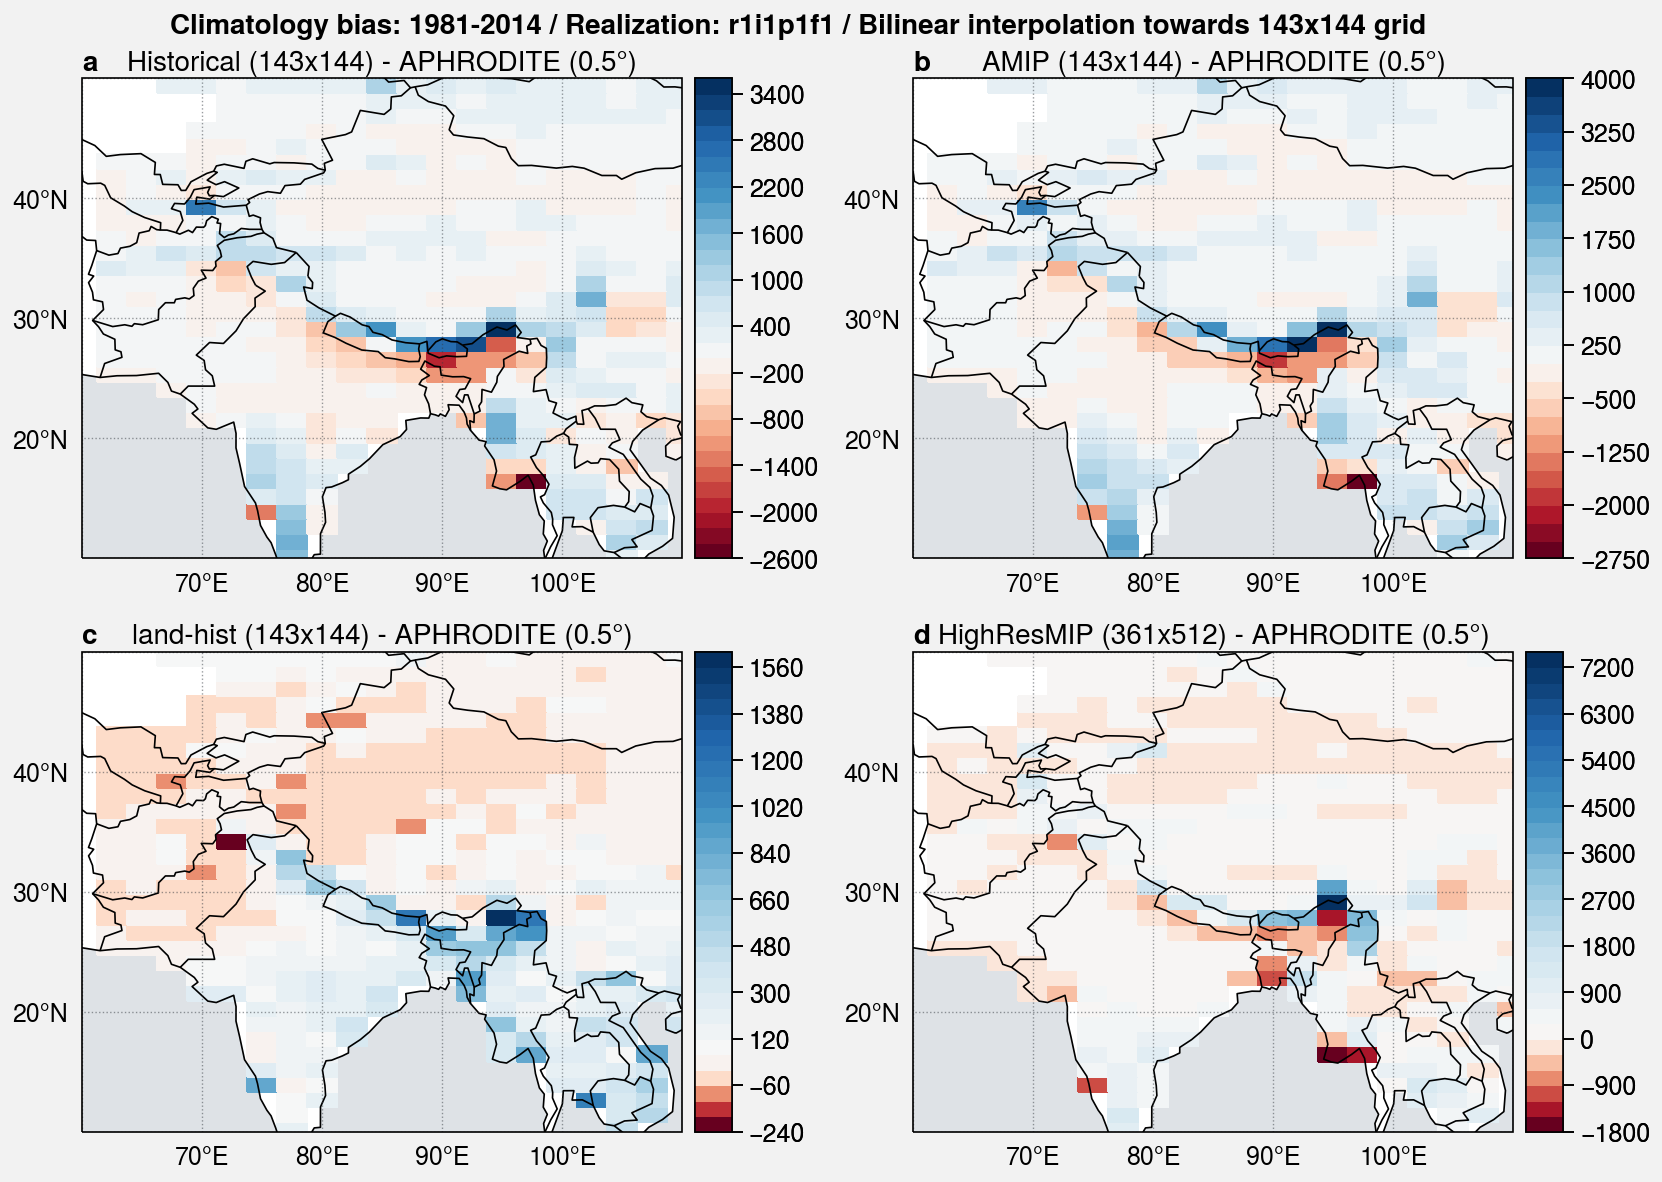

In [24]:
# Check colorbars extent

f, axs = plot.subplots(proj='cyl', ncols=2, nrows=2, share=3, axwidth=3)

for i, ax in enumerate(axs):
    m = ax.pcolormesh(
        bias.isel(bias=i), 
        cmap='RdBu',  
        colorbar='r',
        norm='midpoint',
        levels=30
    )
    ax.format(title=str(bias.isel(bias=i).bias.values))

axs.format(
    geogridlinewidth=0.5, geogridcolor='gray8', geogridalpha=0.5, labels=True, 
    coast=True, ocean=True, oceancolor='gray3', borders=True,
    suptitle="Climatology bias: 1981-2014 / Realization: r1i1p1f1 / Bilinear interpolation towards 143x144 grid",
    lonlines=10, latlines=10, abc=True, latlim=latlim, lonlim=lonlim
)

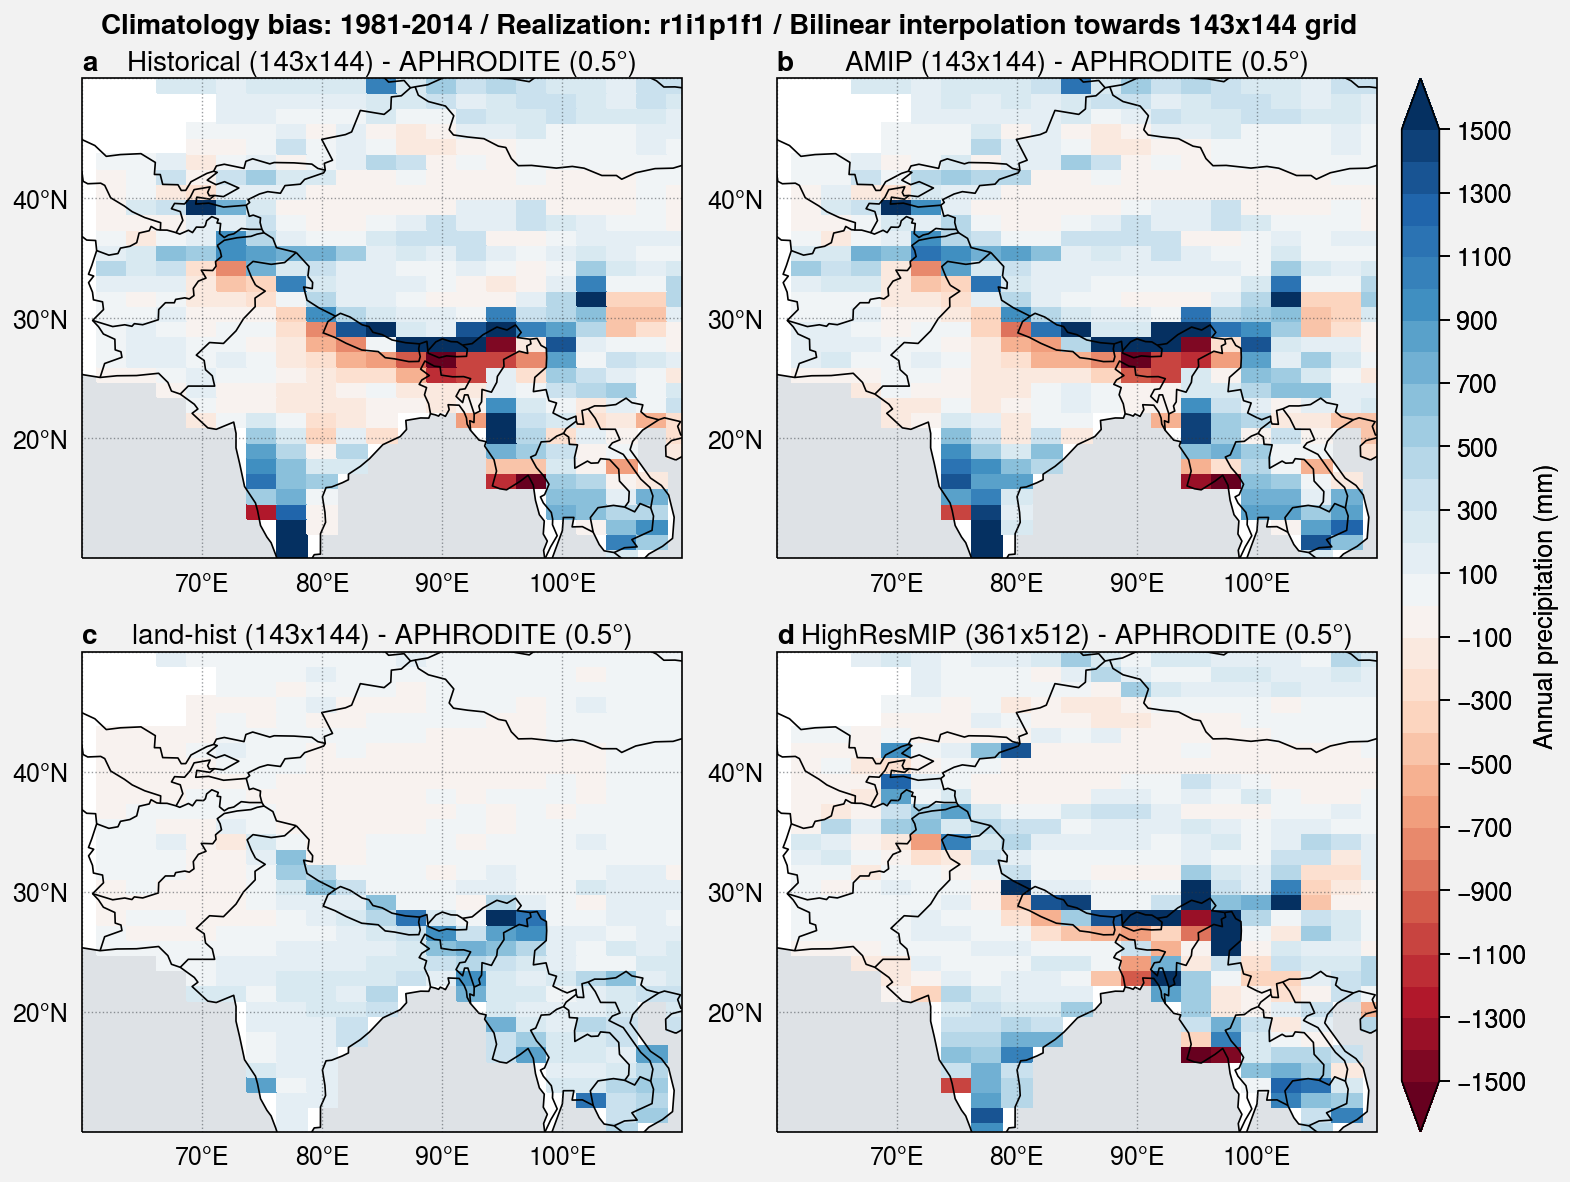

In [25]:
# Final plot

f, axs = plot.subplots(proj='cyl', ncols=2, nrows=2, share=3, axwidth=3)

for i, ax in enumerate(axs):
    m = ax.pcolormesh(
        bias.isel(bias=i), 
        cmap='RdBu', 
        levels=plot.arange(-1500,1500,100), 
        extend='both',
#         norm='midpoint'
    )
    ax.format(title=str(bias.isel(bias=i).bias.values))

f.colorbar(m, label='Annual precipitation (mm)')

axs.format(
    geogridlinewidth=0.5, geogridcolor='gray8', geogridalpha=0.5, labels=True, 
    coast=True, ocean=True, oceancolor='gray3', borders=True,
    suptitle="Climatology bias: 1981-2014 / Realization: r1i1p1f1 / Bilinear interpolation towards 143x144 grid",
    lonlines=10, latlines=10, abc=True, latlim=latlim, lonlim=lonlim
)

f.save('img/precip_IPSL_CMIP6_bias.pdf')

# Link with orography?

In [26]:
orog = xr.open_dataarray(
    '/bdd/CMIP6/CMIP/IPSL/IPSL-CM6A-LR/historical/r1i1p1f1/fx/orog/gr/latest/orog_fx_IPSL-CM6A-LR_historical_r1i1p1f1_gr.nc'
).sel(lat=slice(latlim[0],latlim[1]), lon=slice(lonlim[0],lonlim[1]))
orog

mean_topo = xr.open_dataarray('mean_topo.nc').sel(lat=slice(latlim[0],latlim[1]), lon=slice(lonlim[0],lonlim[1]))
std_topo = xr.open_dataarray('std_topo.nc').sel(lat=slice(latlim[0],latlim[1]), lon=slice(lonlim[0],lonlim[1]))

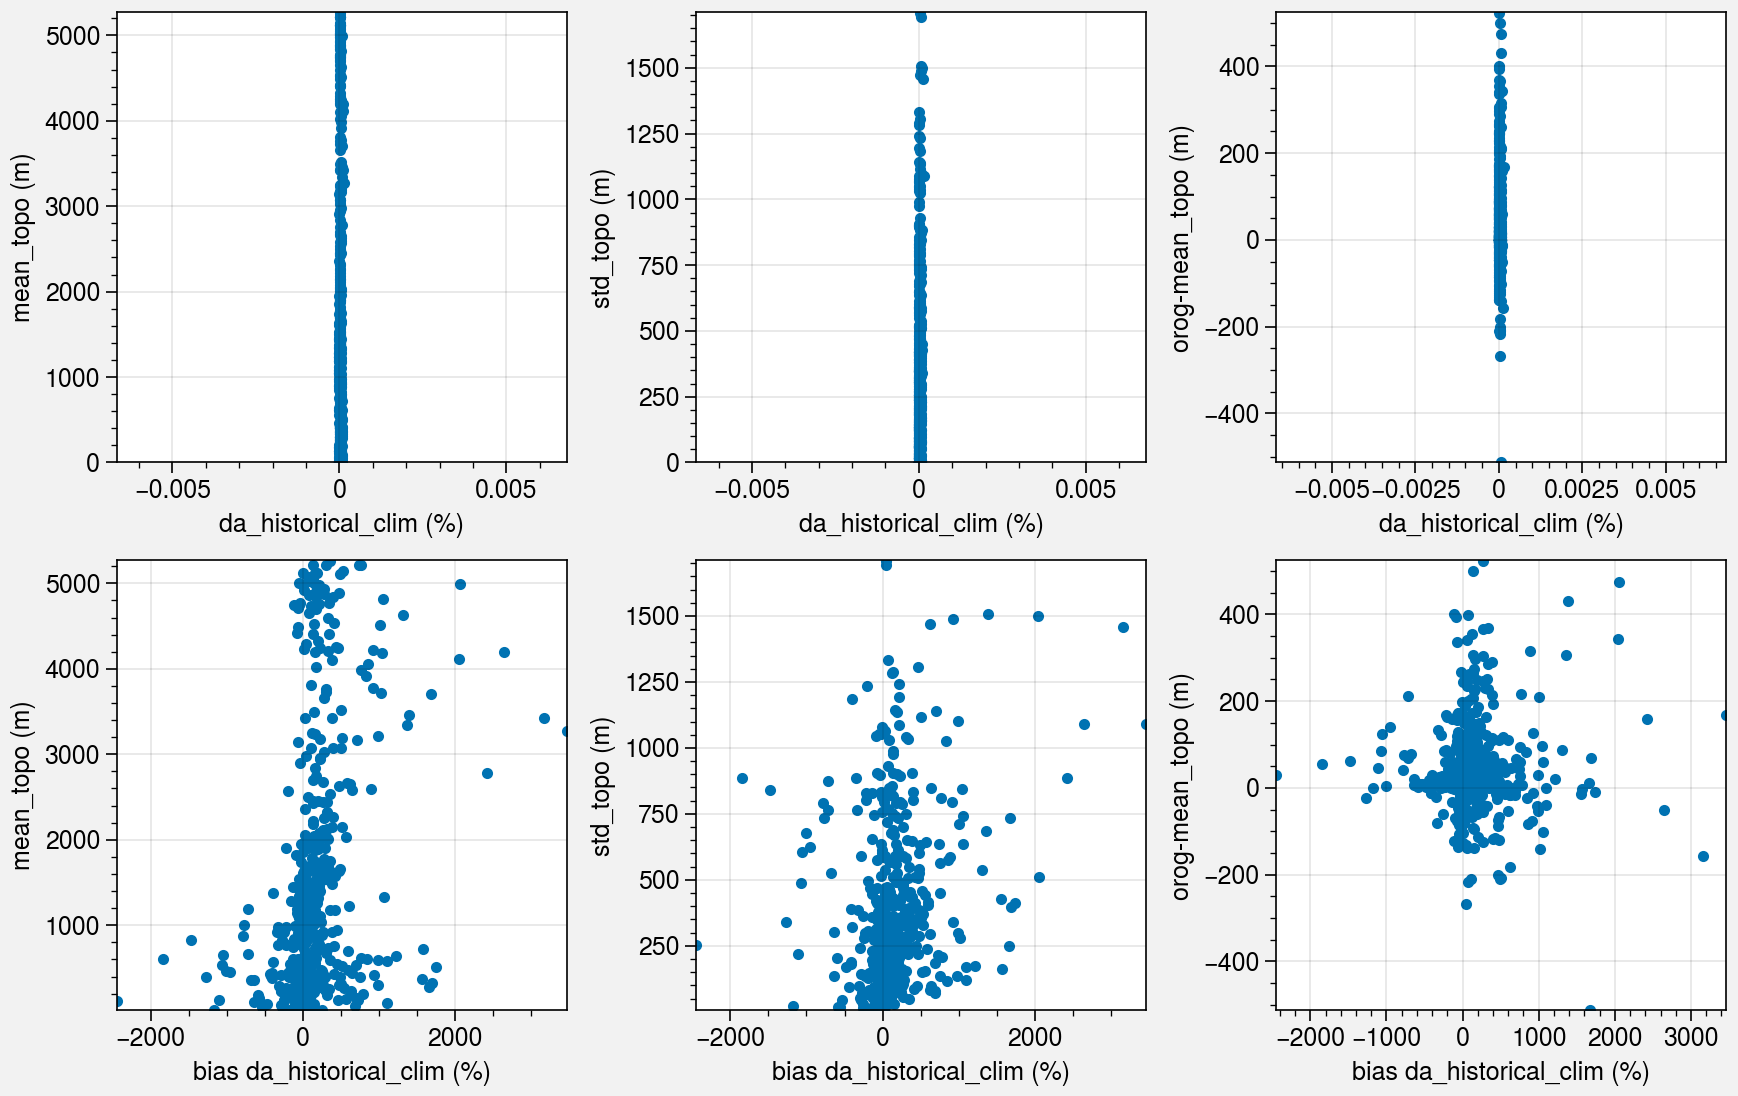

In [27]:
f, axs = plot.subplots(nrows=2, ncols=3, share=0)

axs[0].scatter(
    da_historical_clim.sel(lat=slice(latlim[0],latlim[1]), lon=slice(lonlim[0],lonlim[1])).values.flatten(),
    mean_topo.sel(lat=slice(latlim[0],latlim[1]), lon=slice(lonlim[0],lonlim[1])).values.flatten()
)
axs[0].format(xlabel='da_historical_clim (%)', ylabel='mean_topo (m)')

axs[1].scatter(
    da_historical_clim.sel(lat=slice(latlim[0],latlim[1]), lon=slice(lonlim[0],lonlim[1])).values.flatten(),
    std_topo.sel(lat=slice(latlim[0],latlim[1]), lon=slice(lonlim[0],lonlim[1])).values.flatten()
)
axs[1].format(xlabel='da_historical_clim (%)', ylabel='std_topo (m)')

axs[2].scatter(
    da_historical_clim.sel(lat=slice(latlim[0],latlim[1]), lon=slice(lonlim[0],lonlim[1])).values.flatten(),
    (orog-mean_topo).sel(lat=slice(latlim[0],latlim[1]), lon=slice(lonlim[0],lonlim[1])).values.flatten()
)
axs[2].format(xlabel='da_historical_clim (%)', ylabel='orog-mean_topo (m)')


axs[3].scatter(
    bias[0].sel(lat=slice(latlim[0],latlim[1]), lon=slice(lonlim[0],lonlim[1])).values.flatten(),
    mean_topo.sel(lat=slice(latlim[0],latlim[1]), lon=slice(lonlim[0],lonlim[1])).values.flatten()
)
axs[3].format(xlabel='bias da_historical_clim (%)', ylabel='mean_topo (m)')

axs[4].scatter(
    bias[0].sel(lat=slice(latlim[0],latlim[1]), lon=slice(lonlim[0],lonlim[1])).values.flatten(),
    std_topo.sel(lat=slice(latlim[0],latlim[1]), lon=slice(lonlim[0],lonlim[1])).values.flatten()
)
axs[4].format(xlabel='bias da_historical_clim (%)', ylabel='std_topo (m)')

axs[5].scatter(
    bias[0].sel(lat=slice(latlim[0],latlim[1]), lon=slice(lonlim[0],lonlim[1])).values.flatten(),
    (orog-mean_topo).sel(lat=slice(latlim[0],latlim[1]), lon=slice(lonlim[0],lonlim[1])).values.flatten()
)
axs[5].format(xlabel='bias da_historical_clim (%)', ylabel='orog-mean_topo (m)')

# Annual cycle on the bias zone

In [31]:
lonlim_zone=(78,78+20)
latlim_zone=(27,27+11)

# Compute annual cycles on the zone
ac_historical = u.annual_cycle(u.spatial_average(
    da_historical.sel(lon=slice(lonlim_zone[0],lonlim_zone[1]), lat=slice(latlim_zone[0],latlim_zone[1]))*86400
)).load()
ac_amip = u.annual_cycle(u.spatial_average(
    da_amip.sel(lon=slice(lonlim_zone[0],lonlim_zone[1]), lat=slice(latlim_zone[0],latlim_zone[1]))*86400
)).load()
ac_land_hist = u.annual_cycle(u.spatial_average(
    da_land_hist.sel(lon=slice(lonlim_zone[0],lonlim_zone[1]), lat=slice(latlim_zone[0],latlim_zone[1]))*86400
)).load()
ac_obs_regrid = u.annual_cycle(u.spatial_average(
    obs_regrid.sel(lon=slice(lonlim_zone[0],lonlim_zone[1]), lat=slice(latlim_zone[0],latlim_zone[1]))
)).load()
ac_HR_regrid = u.annual_cycle(u.spatial_average(
    da_HR_regrid.sel(lon=slice(lonlim_zone[0],lonlim_zone[1]), lat=slice(latlim_zone[0],latlim_zone[1]))*86400
)).load()

/home/mlalande/miniconda3/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: divide by zero encountered in true_divide
  x = np.divide(x1, x2, out)
/home/mlalande/miniconda3/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/mlalande/miniconda3/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: divide by zero encountered in true_divide
  x = np.divide(x1, x2, out)
/home/mlalande/miniconda3/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


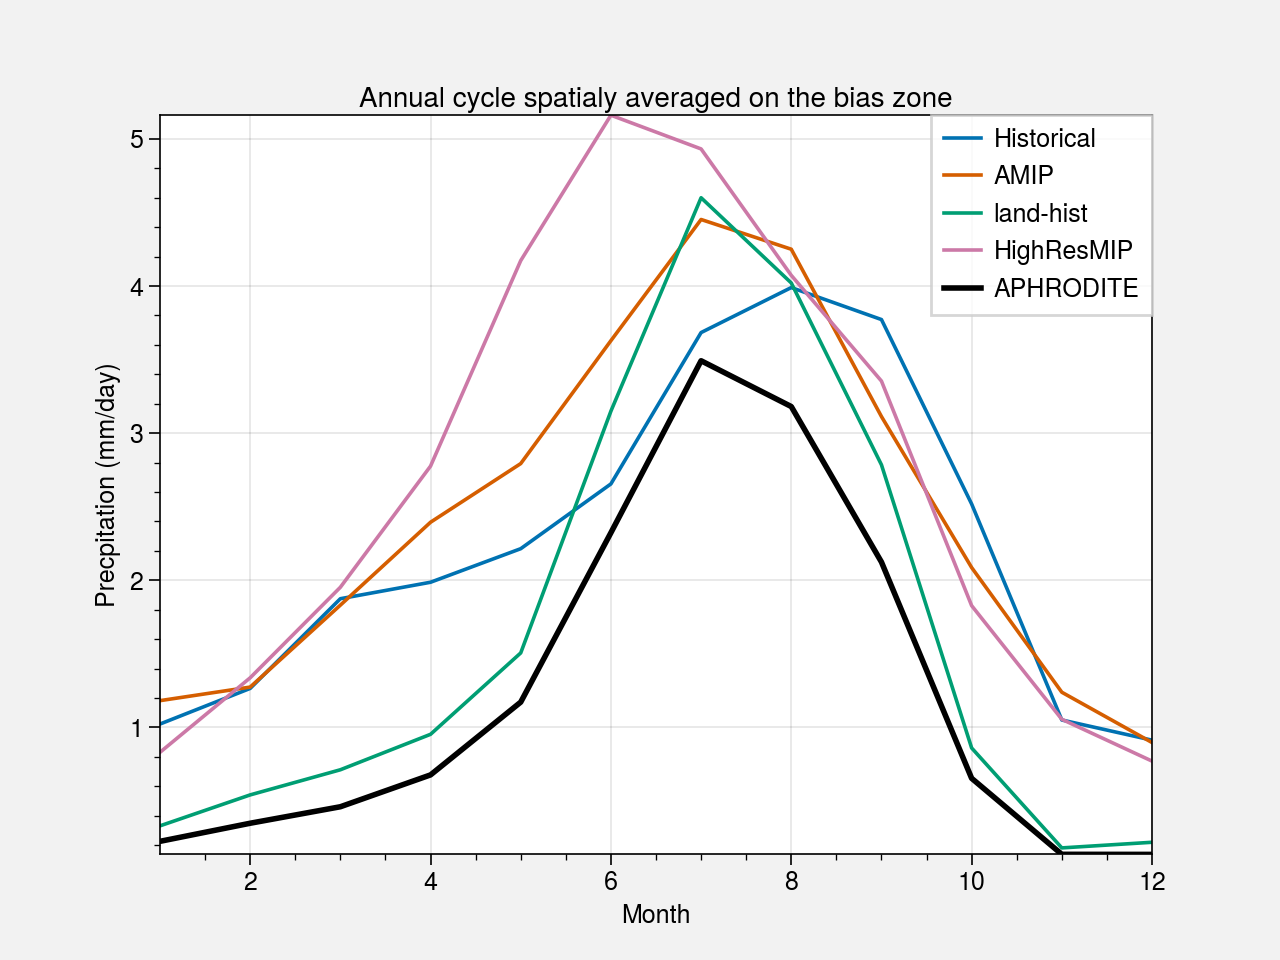

In [34]:
plt.figure()

ac_historical.plot(label='Historical')
ac_amip.plot(label='AMIP')
ac_land_hist.plot(label='land-hist')
ac_HR_regrid.plot(label='HighResMIP')

ac_obs_regrid.plot(label='APHRODITE', color='black', linewidth=2)

plt.title('Annual cycle spatialy averaged on the bias zone')
# plt.ylim(0,100)
plt.ylabel('Precpitation (mm/day)')
plt.xlabel('Month')
plt.legend()

# plt.savefig('img/ac_precip_IPSL_CMIP6.pdf')

# Check ensemble dispersion for historical

In [40]:
da_historical_ens = xr.open_mfdataset(
    '/bdd/CMIP6/CMIP/'+institute+'/'+model+'/historical/*/'+table+'/'+var+'/gr/latest/*.nc', combine='nested', concat_dim='realization', parallel=True
).sel(time=period, lon=slice(lonlim_zone[0],lonlim_zone[1]), lat=slice(latlim_zone[0],latlim_zone[1]))[var]
da_historical_ens

<xarray.DataArray 'pr' (realization: 32, time: 408, lat: 8, lon: 8)>
dask.array<getitem, shape=(32, 408, 8, 8), dtype=float32, chunksize=(1, 408, 8, 8), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 1981-01-16T12:00:00 ... 2014-12-16T12:00:00
  * lat      (lat) float32 27.887323 29.15493 30.422535 ... 35.492958 36.760563
  * lon      (lon) float32 80.0 82.5 85.0 87.5 90.0 92.5 95.0 97.5
Dimensions without coordinates: realization
Attributes:
    long_name:           Precipitation
    units:               kg m-2 s-1
    online_operation:    average
    cell_methods:        area: time: mean
    interval_operation:  900 s
    interval_write:      1 month
    standard_name:       precipitation_flux
    description:         at surface; includes both liquid and solid phases fr...
    history:             none
    cell_measures:       area: areacella

In [42]:
ac_historical_ens = u.annual_cycle(u.spatial_average(da_historical_ens)).load()

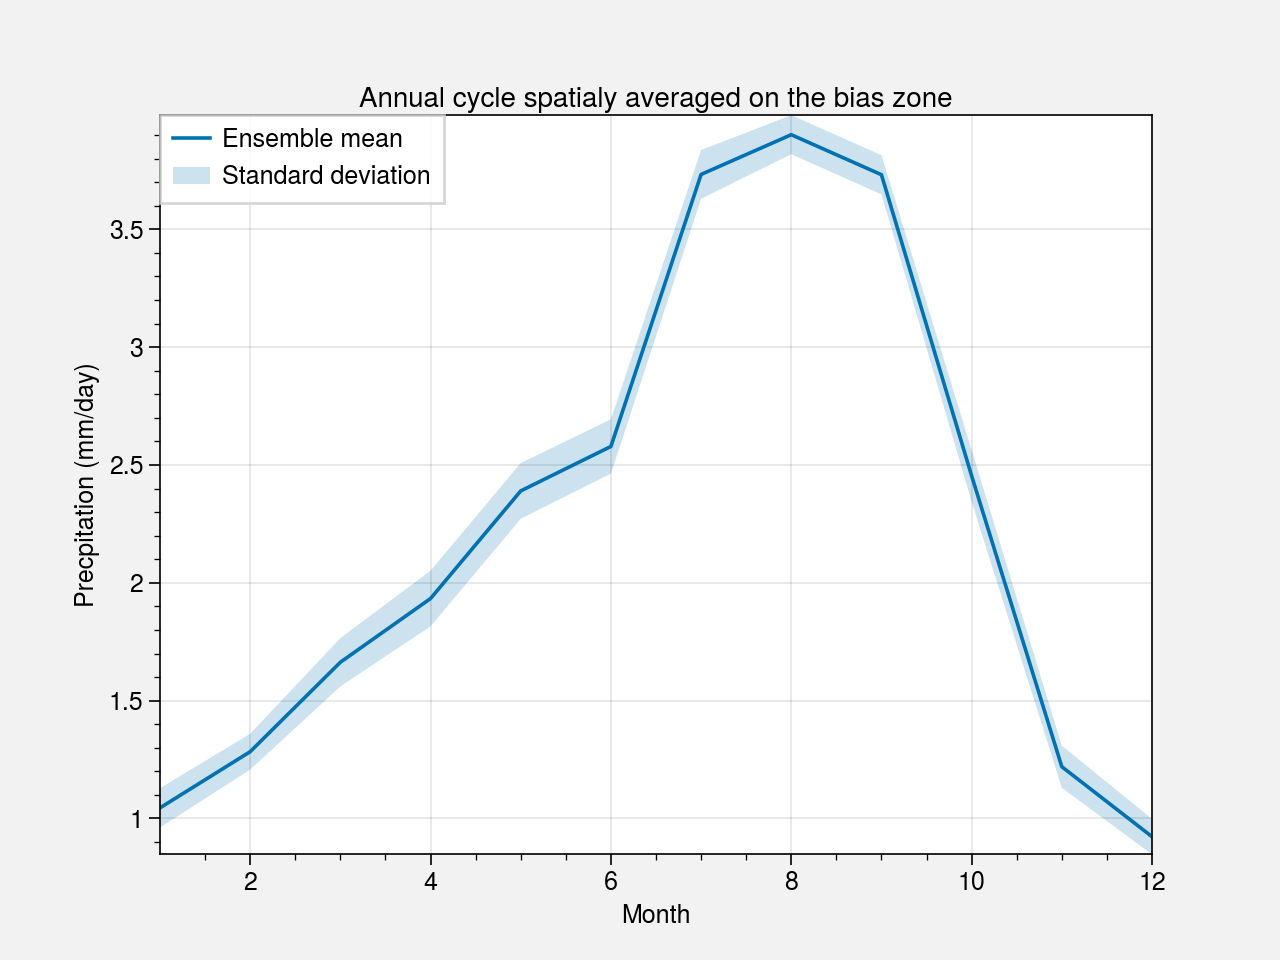

In [45]:
x = ac_historical_ens.month
y = (ac_historical_ens*86400).mean('realization')
std = (ac_historical_ens*86400).std('realization')

fig, ax = plt.subplots()

y.plot(ax=ax, label='Ensemble mean')
ax.fill_between(x, y-std, y+std, alpha=0.2, label='Standard deviation')

plt.title('Annual cycle spatialy averaged on the bias zone')
# plt.ylim(0,100)
plt.ylabel('Precpitation (mm/day)')
plt.xlabel('Month')
plt.legend()

Text(0.5, 0, 'Month')

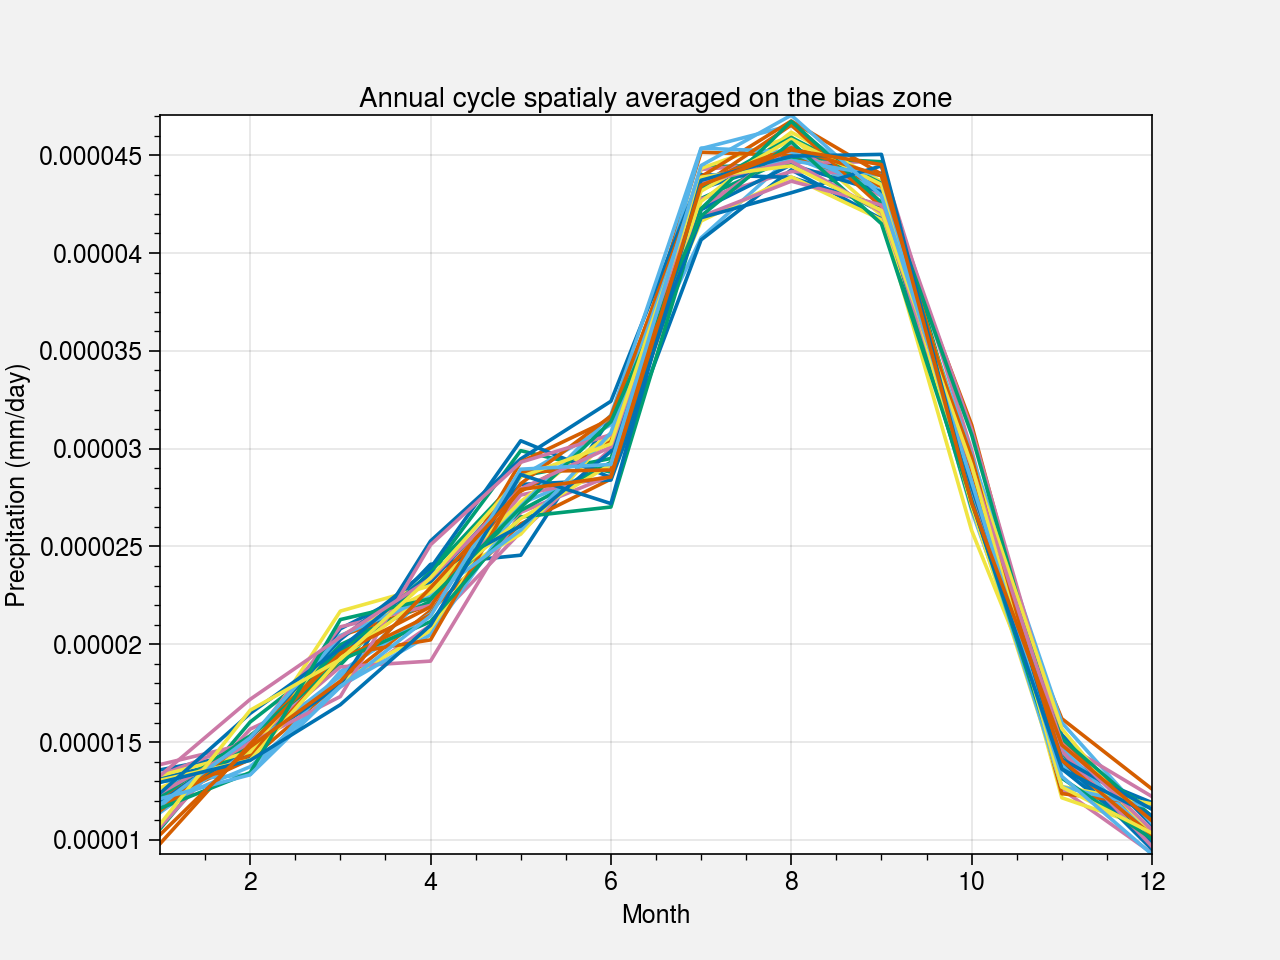

In [47]:
fig, ax = plt.subplots()

for i in ac_historical_ens.realization.values:
    ac_historical_ens[i].plot(ax=ax)

plt.title('Annual cycle spatialy averaged on the bias zone')
# plt.ylim(0,100)
plt.ylabel('Precpitation (mm/day)')
plt.xlabel('Month')
# plt.legend()